# Identification With Surrogates

Causal identification is usually framed as a problem where one wishes to recover some causal query $p(Y | do(a))$ from some observed data distribution $p(V)$ ([Shpitser and Pearl, 2006](https://www.aaai.org/Papers/AAAI/2006/AAAI06-191.pdf); [Huang and Valtorta, 2006](https://www.cse.sc.edu/~mgv/papers/HuangValtortaUAI06.pdf)). Recall $p(Y(a))$ and $p(Y|do(a))$ are equivalent but the do-notation used here is notationally cleaner.

However, recently there has been interest in the scenario where identification is performed with respect to other distributions. An analyst might have access to a set of experiments (where certain variables have been intervened to fixed values), and while the causal query might not be identified in any one experiment, jointly they might suffice. [Lee et al., 2019](https://causalai.net/r46.pdf) provide a sound and complete algorithm when the experiments are of the form $p(V \setminus X | do(x))$ for some intervened variables $X=x$. 

[Lee and Shpitser, 2020](https://arxiv.org/abs/2004.01157) (a different Lee!) extend the applicability of this algorithm by showing that it remains sound and complete for experiments which are ancestral subgraphs, with respect to the original graph under the intervention of the experiment, while recasting the results of Lee et al., 2019 using the one-line ID formulation provided in Richardson et al. 2017.

Following are the necessary packages that need to be imported.

In [21]:
from ananke import graphs
from ananke import identification

Let's say that we are interested in a system represented by the following graph. We can think of $X1$ as a treatment for cardiac disease, $X2$ as a treatment for obesity (say a particular diet), $W$ as blood pressure (which perhaps for the purposes of this toy example is influenced only by the cardiac treatment), and $Y$ as the final health outcome. As a first pass, we may posit the following causal graph, indicating that we only believe unmeasured confounding to exist between a person's treatment assignment and diet. We are interested in the causal query represented by $p(Y | do(x_1, x_2))$.

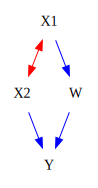

In [22]:
vertices = ["X1", "X2", "W", "Y"]
di_edges = [("X1", "W"), ("W", "Y"), ("X2", "Y")]
bi_edges = [("X1", "X2")]
G = graphs.ADMG(vertices, di_edges, bi_edges)
G.draw(direction="TD")

If we query the `OneLineID` algorithm in Ananke, we will see that this query is indeed identified.

In [23]:
one_id = identification.OneLineID(graph=G, treatments=['X1', 'X2'], outcomes=['Y'])
one_id.id()

True

However, since we are in a clinical healthcare setting, we should expect the presence of more confounding variables. So we update our causal graph to include other hidden confounders between the treatments and outcomes.

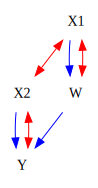

In [24]:
vertices = ["X1", "X2", "W", "Y"]
di_edges = [("X1", "W"), ("W", "Y"), ("X2", "Y")]
bi_edges = [("X1", "X2"), ("X1", "W"), ("X2", "Y")]
G = graphs.ADMG(vertices, di_edges, bi_edges)
G.draw(direction="TD")

We can now verify that under this model, the query is not identified from the observed data distribution $p(V) := p(Y, W, X_2, X_1)$ using `OnelineID`:

In [25]:
one_id = identification.OneLineID(graph=G, treatments=['X1', 'X2'], outcomes=['Y'])
one_id.id()

False

It seems that we are stuck! However, in the next section we discuss how access to smaller subsets of experimental data on the variables involved may help us identify our causal query.


## GID

What if we had access to experiments? We construct two experiments - one where $X_1$ is fixed to value $x_1$, and another where $X_2$ is fixed to value $x_2$. Perhaps, it is not possible to run an experiment where both $X_1$ and $X_2$ are intervened upon (financial reasons, ethical reasons, etc.) but these smaller experiments are indeed possible. 

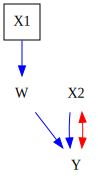

In [26]:
vertices = ["X1", "X2", "W", "Y"]
di_edges = [("X1", "W"), ("W", "Y"), ("X2", "Y")]
bi_edges = [("X1", "X2"), ("X1", "W"), ("X2", "Y")]
G1 = graphs.ADMG(vertices, di_edges, bi_edges)
G1.fix(["X1"])
G1.draw(direction="TD")

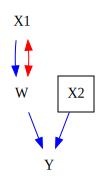

In [27]:
vertices = ["X1", "X2", "W", "Y"]
di_edges = [("X1", "W"), ("W", "Y"), ("X2", "Y")]
bi_edges = [("X1", "X2"), ("X1", "W"), ("X2", "Y")]
G2 = graphs.ADMG(vertices, di_edges, bi_edges)
G2.fix(["X2"])
G2.draw(direction="TD")

It happens that the causal query is indeed identified:

In [28]:
g_id = identification.OneLineGID(graph=G, treatments=["X1", "X2"], outcomes=["Y"])

In [29]:
g_id.id(experiments=[G1, G2])

True

with corresponding identifying functional 

In [30]:
g_id.functional(experiments=[G1, G2])

'ΣW ΦX2,Y p(W,X2,Y | do(X1))ΦX1,W p(W,X1,Y | do(X2))'

## AID

The astute reader will notice that perhaps we didn't need all of the experimental distributions. Rather, a margin would have sufficed - on the first experiment, we could have marginalized $Y$ and $X_2$, and still achieved identification. The reason is that the intrinsic set (and its parents) would have been identified anyways. Based on the results provided in Lee and Shpitser, 2020, we consider identification from the following experiment. The first graph is an ancestral subgraph with respect to $G(V(x_1))$. The second graph remains unchanged, as does the graph defining the system we are interested in.

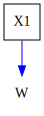

In [31]:
vertices = ["X1","W"]
di_edges = [("X1", "W")]
bi_edges = [("X1", "W")]
G1 = graphs.ADMG(vertices, di_edges, bi_edges)
G1.fix(["X1"])
G1.draw(direction="TD")

In [32]:
a_id = identification.OneLineAID(graph=G, treatments=["X1", "X2"], outcomes=["Y"])

In [33]:
a_id.id(experiments=[G1, G2])

True

In [34]:
a_id.functional(experiments=[G1, G2])

'ΣW  p(W | do(X1))ΦX1,W p(W,X1,Y | do(X2))'

The causal query remains identified, but the identification formula has changed. Notably, no fixing operations are needed under the first experiment $p(W | do(X1))$ since it is exactly the required kernel.